### Notebook to prototype REDCap API calls

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import nipoppy.workflow.logger as","my_logger
import seaborn as sns
import nipoppy.workflow.utils as utils
from itertools import product

In [2]:
def api_call(url, query, logger):
    r = requests.post(url, data=query, verify=False)
    http_status = str(r.status_code)
    logger.info(f'HTTP Status: {http_status}')

    if http_status == "200":
        query_results = r.json()
        query_df = pd.DataFrame(query_results)

    else:
        logger.error(f"RedCap API request Failed with HTTP Status: {http_status}")

    return query_df

In [3]:
DATASET_ROOT = "/home/nikhil/projects/Parkinsons/qpn/"

# Current nipoppy manifest
release_dir = f"{DATASET_ROOT}/releases/"
current_release = "Sept_2023"
current_nipoppy_manifest_csv = f"{release_dir}{current_release}/tabular/manifest.csv"
legacy_qpn_imaging_codes_xlsx = f"{release_dir}{current_release}/tabular/QPN_Imaging_Codes.xlsx"

# log
log_dir = f"{DATASET_ROOT}/scratch/logs/"
log_file = f"{log_dir}/bids_conv.log"
logger = my_logger.get_logger(log_file)

# Available queires (i.e. redcap reports)
# redcap_reports = ["QPN participants", "External QPN (June 2021)", "MoCA-MDS-UPDRS part 3", "Victoria - Weston Project",
#                   "MotorAndNon-Motor"]

### Manifest

In [4]:
visit_list = ["MRI_v1"] 
session_id_list = ["01"]
session_list = [f"ses-{idx}" for idx in session_id_list]

manifest_cols = ["participant_id", "visit", "session"]

current_nipoppy_manifest_df = pd.read_csv(current_nipoppy_manifest_csv)
current_nipoppy_manifest_df = current_nipoppy_manifest_df[current_nipoppy_manifest_df["visit"].isin(visit_list)]
current_nipoppy_manifest_df = current_nipoppy_manifest_df[current_nipoppy_manifest_df["session"].isin(session_list)]
current_nipoppy_manifest_df = current_nipoppy_manifest_df[manifest_cols]
current_nipoppy_manifest_df["participant_id"] = current_nipoppy_manifest_df["participant_id"].str.upper()
nipoppy_participants = current_nipoppy_manifest_df["participant_id"].unique()
n_participants = len(nipoppy_participants)
logger.info(f"n_participants: {n_participants}")
current_nipoppy_manifest_df.head()

2023-11-08 15:45:05,395 - nipoppy.workflow.logger - INFO - n_participants: 265


,participant_id,visit,session
0,PD00016,MRI_v1,ses-01
1,PD00020,MRI_v1,ses-01
2,PD00032,MRI_v1,ses-01
3,PD00048,MRI_v1,ses-01
4,PD00119,MRI_v1,ses-01


### Legacy demographics and visit dates
- Using this while REDCap is getting updated

In [5]:
sheet_name = "recruit_manifest"
usecols = ["participant_id", "group", "sex", "dob", "visit_01"]
legacy_recruit_manifest = pd.read_excel(legacy_qpn_imaging_codes_xlsx, sheet_name=sheet_name, engine='openpyxl', usecols=usecols)
legacy_recruit_manifest = legacy_recruit_manifest.rename(columns={"visit_01": "date_MRI_V01"})
legacy_recruit_manifest["participant_id"] = legacy_recruit_manifest["participant_id"].str.upper()

legacy_participants = legacy_recruit_manifest["participant_id"].unique()
n_legacy_participants = len(legacy_participants)
logger.info(f"n_legacy_participants: {n_legacy_participants}")

legacy_recruit_manifest["dob"] = pd.to_datetime(legacy_recruit_manifest["dob"], errors="coerce", dayfirst=True)
legacy_recruit_manifest["date_MRI_V01"] = pd.to_datetime(legacy_recruit_manifest["date_MRI_V01"], errors="coerce", dayfirst=True)

# calculate age at MRI_V01
legacy_recruit_manifest["age_MRI_V01"] = legacy_recruit_manifest["date_MRI_V01"] - legacy_recruit_manifest["dob"]
legacy_recruit_manifest["age_MRI_V01"] = np.round(legacy_recruit_manifest["age_MRI_V01"].dt.days / 365.25, 1)
legacy_recruit_manifest.head()


2023-11-08 15:45:06,887 - nipoppy.workflow.logger - INFO - n_legacy_participants: 208


,participant_id,sex,dob,group,date_MRI_V01,age_MRI_V01
0,MNI0056,M,1942-05-21,PD,2021-08-18,79.2
1,MNI0058,M,1964-03-14,PD,2021-08-18,57.4
2,MNI0068,M,1952-08-05,PD,2021-08-27,69.1
3,MNI0079,F,1971-11-25,PD,2021-12-22,50.1
4,MNI0103,M,1939-08-17,PD,2021-08-11,82.0


In [6]:
legacy_recruit_manifest.groupby("group").count()

,participant_id,sex,dob,date_MRI_V01,age_MRI_V01
group,,,,,
CTRL,41,41,40,41,40
PD,166,166,166,166,166


### Redcap config

In [7]:
redcap_config_json = f"{DATASET_ROOT}/proc/.redcap.json"
redcap_config = json.load(open(redcap_config_json))
url = redcap_config["url"]
redcap_reports = list(redcap_config["queries"].keys())
n_redcap_reports = len(redcap_reports)
logger.info(f"redcap_reports ({n_redcap_reports}): {redcap_reports}")

2023-11-08 15:45:06,936 - nipoppy.workflow.logger - INFO - redcap_reports (10): ['QPN participants', 'External QPN (June 2021)', 'Demographic QPN', 'QPN-Clinical questionnaire', 'QPN sex', 'Diagnosis QPN', 'MoCA-MDS-UPDRS part 3', 'Victoria - Weston Project', 'MotorAndNon-Motor', 'MoCA']


In [8]:
query_dict = {}
redcap_participants = []
for query_label in redcap_reports:
    query = redcap_config["queries"][query_label]

    # run query
    logger.info(f"Running query {query_label}...")
    query_df = api_call(url, query, logger=logger)
    query_df["record_id"] = query_df["record_id"].str.upper()

    # get the list of participants
    _participants = query_df["record_id"].unique()
    redcap_participants.extend(_participants)
    n_participants = len(redcap_participants)

    # get the list of redcap events
    redcap_events = query_df["redcap_event_name"].unique()
    n_events = len(redcap_events)

    logger.info(f"Fetched {n_participants} participants and {n_events} event_ids: {redcap_events}")

    query_dict[query_label] = query_df.copy()

2023-11-08 15:45:06,948 - nipoppy.workflow.logger - INFO - Running query QPN participants...
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'redcap.cru.ucalgary.ca'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
2023-11-08 15:45:08,093 - nipoppy.workflow.logger - INFO - HTTP Status: 200
2023-11-08 15:45:08,106 - nipoppy.workflow.logger - INFO - Fetched 264 participants and 7 event_ids: ['Baseline (Arm 1: C-OPN)' '12 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '18 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '72 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '60 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '36 Months Follow-Up/Suivi (Arm 1: C-OPN)'
 '24 Months Follow-Up/Suivi (Arm 1: C-OPN)']
2023-11-08 15:45:08,110 - nipoppy.workflow.logger - INFO - Running query External QPN (June 2

In [9]:
# redcap_participants = [p.upper() for p in redcap_participants]

a = set(redcap_participants)
b = set(nipoppy_participants)
c = set(legacy_participants)

nipoppy_redcap_common_participants = a.intersection(b)
n_redcap_common_participants = len(nipoppy_redcap_common_participants)
nipoppy_legacy_common_participants = b.intersection(c)
n_legacy_common_participants = len(nipoppy_legacy_common_participants)

new_redcap_participants  = a.difference(b)
n_new_redcap_participants = len(new_redcap_participants)
new_nipoppy_participants  = b.difference(a)
n_new_nipoppy_participants = len(new_nipoppy_participants)

logger.info(f"Found {n_redcap_common_participants} recdap-nipoppy common participants")
logger.info(f"Found {n_legacy_common_participants} legacy-nipoppy common participants")
logger.info(f"Found {n_new_redcap_participants} new redcap participants")
logger.info(f"Found {n_new_nipoppy_participants} new nipoppy participants")

2023-11-08 15:45:26,412 - nipoppy.workflow.logger - INFO - Found 256 recdap-nipoppy common participants
2023-11-08 15:45:26,415 - nipoppy.workflow.logger - INFO - Found 206 legacy-nipoppy common participants
2023-11-08 15:45:26,419 - nipoppy.workflow.logger - INFO - Found 1089 new redcap participants
2023-11-08 15:45:26,421 - nipoppy.workflow.logger - INFO - Found 9 new nipoppy participants


### Demographics, Dx, and summary clinical scores
- `Demographic QPN`
    - "study_visit_age", "gender", "yrs_education"
        - Note: study visit age will be different for different assessments
- `Diagnosis QPN` does not have Dx for all participants
- `Victoria - Weston Project` (Legend for Determined diagnosis)
    - If score = 0, Parkinson's Disease (PD)  
    - If score = 1, Progressive Supranuclear Palsy (PSP)  
    - If score = 2, Multiple System Atrophy (MSA) 
    - If score = 3, Corticobasal Syndrome (CBS)  
    - If score = 4, Dementia wi1th Lewy Bodies (DLB)  
    - If score = 5, Frontotemporal Dementia (FTD)  
    - If score = 6, Essential Tremor (ET)  
    - If score = 7, REM Sleep Behaviour Disorder (RBD)
- `MotorAndNon-Motor` 
    - summary clinical scores (updrs, moca)
    - verify moca column with extra point i.e. `moca_extra_point`


### Aggregate useful redcap data

In [10]:
index_columns = ["record_id", "redcap_event_name"]

demo_cols = ["study_visit_age", "gender", "yrs_education"]
demo_df = query_dict['Demographic QPN'][index_columns + demo_cols].copy()

dx_cols = ["diagnosis_determined", "duration_disease"]
dx_df = query_dict['Victoria - Weston Project'][index_columns + dx_cols]

diagnosis_determined_label_map = {
    "0" : "PD",
    "1" : "PSP",
    "2" : "MSA",
    "3" : "CBS", 
    "4" : "DLB",
    "5" : "FTD", 
    "6" : "ET",
    "7" : "RBD"
}
dx_df.loc[:,"diagnosis_determined"] = dx_df["diagnosis_determined"].astype(str).replace(diagnosis_determined_label_map).copy()

updrs_cols = ["mds_updrs_h_y", "updrs_score_part_1", "updrs_score_part_2", "updrs_score_part_3", "updrs_score_part_4"]
moca_cols = ['moca_result'] 
moca_subscore_cols = ['moca_result_2', 'moca_result_3', 'moca_result_4','moca_result_5', 'moca_result_6', 
                      'moca_result_7', 'moca_result_8','moca_result_9']

score_cols = updrs_cols + moca_cols
score_df = query_dict["Victoria - Weston Project"][index_columns + score_cols].copy()

redcap_df = pd.merge(demo_df, dx_df, on=index_columns)
redcap_df = pd.merge(redcap_df, score_df, on=index_columns)

n_redcap_common_participants = len(redcap_df["record_id"].unique())
logger.info(f"Found {n_redcap_common_participants} recdap-nipoppy common participants")

logger.info(f"redcap events: {redcap_df['redcap_event_name'].unique()}")

redcap_df.head()

2023-11-08 15:45:26,504 - nipoppy.workflow.logger - INFO - Found 1345 recdap-nipoppy common participants
2023-11-08 15:45:26,508 - nipoppy.workflow.logger - INFO - redcap events: ['Baseline (Arm 1: C-OPN)']


,record_id,redcap_event_name,study_visit_age,gender,yrs_education,diagnosis_determined,duration_disease,mds_updrs_h_y,updrs_score_part_1,updrs_score_part_2,updrs_score_part_3,updrs_score_part_4,moca_result
0,CHQ0000,Baseline (Arm 1: C-OPN),,Female/Féminin,9,,,,,,,,
1,CHQ0009,Baseline (Arm 1: C-OPN),,,,,,,,,,,
2,CHQ0011,Baseline (Arm 1: C-OPN),70,Male/Masculin,16,PD,5.8,(2) Bilateral involvement without impairment o...,11,8,36,0,24
3,CHQ0012,Baseline (Arm 1: C-OPN),,,,,,,,,,,
4,CHQ0035,Baseline (Arm 1: C-OPN),71,Female/Féminin,14,PD,11.8,(2) Bilateral involvement without impairment o...,6,11,46,7,22


### Merge MRI, legacy and redcap tabular data

In [11]:
nipoppy_redcap_df = redcap_df[(redcap_df["record_id"].str.upper().isin(nipoppy_participants)) & 
                              (redcap_df["redcap_event_name"].isin(["Baseline (Arm 1: C-OPN)"]))].copy()

n_nipoppy_redcap_participants = len(nipoppy_redcap_df["record_id"].unique())
logger.info(f"n_nipoppy_redcap_participants: {n_nipoppy_redcap_participants}")

               
nipoppy_redcap_df = nipoppy_redcap_df.replace("", np.nan)
nipoppy_redcap_df = nipoppy_redcap_df.rename(columns={"record_id": "participant_id"})

nipoppy_redcap_df = pd.merge(nipoppy_redcap_df, legacy_recruit_manifest, on="participant_id", how="left")
nipoppy_redcap_df["gender"] = nipoppy_redcap_df["gender"].replace({"Male/Masculin":"M", "Female/Féminin":"F"})

n_nipoppy_redcap_participants = len(nipoppy_redcap_df["participant_id"].unique())
logger.info(f"n_nipoppy_redcap_participants: {n_nipoppy_redcap_participants}")

redcap_events = nipoppy_redcap_df["redcap_event_name"].unique()
logger.info(f"redcap_events: {redcap_events}")

nipoppy_redcap_df.head()

2023-11-08 15:45:26,553 - nipoppy.workflow.logger - INFO - n_nipoppy_redcap_participants: 256
2023-11-08 15:45:26,562 - nipoppy.workflow.logger - INFO - n_nipoppy_redcap_participants: 256
2023-11-08 15:45:26,564 - nipoppy.workflow.logger - INFO - redcap_events: ['Baseline (Arm 1: C-OPN)']


,participant_id,redcap_event_name,study_visit_age,gender,yrs_education,diagnosis_determined,duration_disease,mds_updrs_h_y,updrs_score_part_1,updrs_score_part_2,updrs_score_part_3,updrs_score_part_4,moca_result,sex,dob,group,date_MRI_V01,age_MRI_V01
0,MNI0056,Baseline (Arm 1: C-OPN),79,M,6,NaN,6.1,(3) Bilateral disease: mild to moderate disabi...,12,22,58,0,22,M,1942-05-21,PD,2021-08-18,79.2
1,MNI0058,Baseline (Arm 1: C-OPN),57,M,11,PD,3.4,"(1) Unilateral involvement only, usually with ...",0,6,26,0,25,M,1964-03-14,PD,2021-08-18,57.4
2,MNI0068,Baseline (Arm 1: C-OPN),69,M,12,PD,9.8,(2) Bilateral involvement without impairment o...,11,8,28,0,NaN,M,1952-08-05,PD,2021-08-27,69.1
3,MNI0079,Baseline (Arm 1: C-OPN),49,F,20+,PD,6.5,(2) Bilateral involvement without impairment o...,13,10,22,8,26,F,1971-11-25,PD,2021-12-22,50.1
4,MNI0103,Baseline (Arm 1: C-OPN),81,M,18,PD,4.3,(2) Bilateral involvement without impairment o...,28,25,43,NaN,20,M,1939-08-17,PD,2021-08-11,82.0


### Generate bagel(s)
- neuro-bagel
- dash-bagel (currenly this is a melted version of neuro-bagel)

**Note**: QPN has different `visit` names for MRI, UPDRS, MoCA, Neuropsy etc.

Using redcap events as evidence of multiple visits. However we are NOT assuming that two assessments (e.g. UPDRS and MoCA) are co-acquired in the same redcap event. This will be inferred using dates once available. 

In [12]:
legacy_demo_cols = ["sex","group"]
redcap_index_cols = ["participant_id", "redcap_event_name"]
redcap_event_visit_id_dict = {"Baseline (Arm 1: C-OPN)": "v1"}

screen_cols = demo_cols + dx_cols + legacy_demo_cols + ["date_MRI_V01"]

screen_cols_rename_dict = {
    "study_visit_age": "age_at_screening",
    "yrs_education": "years_education_at_screening",
    "diagnosis_determined": "diagnosis_at_screening",
    "duration_disease": "duration_disease_at_screening",
    "group": "group_at_screening"
}

screen_df = nipoppy_redcap_df[redcap_index_cols + screen_cols].copy()
screen_df = screen_df.rename(columns=screen_cols_rename_dict)

# ------------------------------------------------------------------------------------ #
# Check and add nipoppy participants which yet don't have any redcap data
# Only populates the participant_id and bids_id columns (required by neurobagel)
# ------------------------------------------------------------------------------------ #
nipoppy_participants_without_pheno_data_df = pd.DataFrame()
nipoppy_participants_without_pheno_data_df["participant_id"] = list(new_nipoppy_participants)
# nipoppy_participants_without_pheno_data_df["bids_id"] = nipoppy_participants_without_pheno_data_df["participant_id"].apply(utils.participant_id_to_bids_id)

screen_df = pd.concat([screen_df, nipoppy_participants_without_pheno_data_df], axis=0)
# ------------------------------------------------------------------------------------ #

screen_df.head()

,participant_id,redcap_event_name,age_at_screening,gender,years_education_at_screening,diagnosis_at_screening,duration_disease_at_screening,sex,group_at_screening,date_MRI_V01
0,MNI0056,Baseline (Arm 1: C-OPN),79,M,6,NaN,6.1,M,PD,2021-08-18
1,MNI0058,Baseline (Arm 1: C-OPN),57,M,11,PD,3.4,M,PD,2021-08-18
2,MNI0068,Baseline (Arm 1: C-OPN),69,M,12,PD,9.8,M,PD,2021-08-27
3,MNI0079,Baseline (Arm 1: C-OPN),49,F,20+,PD,6.5,F,PD,2021-12-22
4,MNI0103,Baseline (Arm 1: C-OPN),81,M,18,PD,4.3,M,PD,2021-08-11


In [13]:
visit_prefix = "UPDRS_"
updrs_df = nipoppy_redcap_df[redcap_index_cols + updrs_cols].copy()
updrs_df["visit_id"] = updrs_df["redcap_event_name"].map(redcap_event_visit_id_dict)
updrs_df["visit"] = visit_prefix + updrs_df["visit_id"]

updrs_df.head()

,participant_id,redcap_event_name,mds_updrs_h_y,updrs_score_part_1,updrs_score_part_2,updrs_score_part_3,updrs_score_part_4,visit_id,visit
0,MNI0056,Baseline (Arm 1: C-OPN),(3) Bilateral disease: mild to moderate disabi...,12,22,58,0,v1,UPDRS_v1
1,MNI0058,Baseline (Arm 1: C-OPN),"(1) Unilateral involvement only, usually with ...",0,6,26,0,v1,UPDRS_v1
2,MNI0068,Baseline (Arm 1: C-OPN),(2) Bilateral involvement without impairment o...,11,8,28,0,v1,UPDRS_v1
3,MNI0079,Baseline (Arm 1: C-OPN),(2) Bilateral involvement without impairment o...,13,10,22,8,v1,UPDRS_v1
4,MNI0103,Baseline (Arm 1: C-OPN),(2) Bilateral involvement without impairment o...,28,25,43,NaN,v1,UPDRS_v1


In [14]:
visit_prefix = "MoCA_"
moca_df = nipoppy_redcap_df[redcap_index_cols + moca_cols].copy()
moca_df["visit_id"] = moca_df["redcap_event_name"].map(redcap_event_visit_id_dict)
moca_df["visit"] = visit_prefix + moca_df["visit_id"]

moca_df.head()

,participant_id,redcap_event_name,moca_result,visit_id,visit
0,MNI0056,Baseline (Arm 1: C-OPN),22,v1,MoCA_v1
1,MNI0058,Baseline (Arm 1: C-OPN),25,v1,MoCA_v1
2,MNI0068,Baseline (Arm 1: C-OPN),NaN,v1,MoCA_v1
3,MNI0079,Baseline (Arm 1: C-OPN),26,v1,MoCA_v1
4,MNI0103,Baseline (Arm 1: C-OPN),20,v1,MoCA_v1


In [15]:
pheno_df = pd.concat([updrs_df, moca_df], axis=0)
pheno_df = pd.merge(screen_df, pheno_df, on=redcap_index_cols, how="left")

pheno_df.loc[:,"bids_id"] = pheno_df["participant_id"].apply(utils.participant_id_to_bids_id)

screen_cols = list(screen_df.columns.drop(redcap_index_cols))
reordered_cols = ["participant_id","bids_id","redcap_event_name","visit_id","visit"] + screen_cols + updrs_cols + moca_cols
pheno_df = pheno_df[reordered_cols].copy()

bagel_df = pheno_df.copy()

bagel_participants = bagel_df["participant_id"].unique()
logger.info(f"n_bagel_participants: {len(bagel_participants)}")

for col in updrs_cols + moca_cols:
    bagel_df[f"{col}_status"] = ~bagel_df[col].isna()
    n_available_participants = np.sum(bagel_df[f"{col}_status"])
    logger.info(f"{col}, n_available_participants: {n_available_participants}")

logger.info(f"bagel df shape: {bagel_df.shape}")
bagel_df.tail()

2023-11-08 15:45:26,704 - nipoppy.workflow.logger - INFO - n_bagel_participants: 265
2023-11-08 15:45:26,706 - nipoppy.workflow.logger - INFO - mds_updrs_h_y, n_available_participants: 129
2023-11-08 15:45:26,708 - nipoppy.workflow.logger - INFO - updrs_score_part_1, n_available_participants: 128
2023-11-08 15:45:26,710 - nipoppy.workflow.logger - INFO - updrs_score_part_2, n_available_participants: 127
2023-11-08 15:45:26,711 - nipoppy.workflow.logger - INFO - updrs_score_part_3, n_available_participants: 130
2023-11-08 15:45:26,714 - nipoppy.workflow.logger - INFO - updrs_score_part_4, n_available_participants: 127
2023-11-08 15:45:26,716 - nipoppy.workflow.logger - INFO - moca_result, n_available_participants: 163
2023-11-08 15:45:26,717 - nipoppy.workflow.logger - INFO - bagel df shape: (521, 25)


,participant_id,bids_id,redcap_event_name,visit_id,visit,age_at_screening,gender,years_education_at_screening,diagnosis_at_screening,duration_disease_at_screening,...,updrs_score_part_2,updrs_score_part_3,updrs_score_part_4,moca_result,mds_updrs_h_y_status,updrs_score_part_1_status,updrs_score_part_2_status,updrs_score_part_3_status,updrs_score_part_4_status,moca_result_status
516,PD01253,sub-PD01253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
517,PD01687,sub-PD01687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
518,PD01662,sub-PD01662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
519,PD01686,sub-PD01686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
520,MNI0147,sub-MNI0147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False


### dash bagel (melt)


In [16]:
# Dashboard variables
DASH_INDEX_COLUMNS = ["participant_id", "visit", "bids_id"]
DASH_NAME_COL = "assessment_name"
DASH_VAL_COL = "assessment_score"

dash_df = pheno_df.melt(id_vars=DASH_INDEX_COLUMNS, var_name=DASH_NAME_COL, value_name=DASH_VAL_COL)
dash_df = dash_df.rename(columns={"visit": "session"})


### save phenotypic data
- Saves `demographics.csv` --> data collected at screening i.e. age, sex, group, education etc. 
- Saves `assessments.csv` i.e. collated data from clinical assessments i.e. UPDRS, MoCA

In [17]:
save_pheno = False

demograph_csv_path = f"{DATASET_ROOT}/tabular/demographics/demographics.csv"
assessment_csv_path = f"{DATASET_ROOT}/tabular/assessments/assessments.csv"

if save_pheno:
    screen_df.to_csv(demograph_csv_path, index=False)
    pheno_df.to_csv(assessment_csv_path, index=False)
    

### save bagels

In [18]:
save_bagels = False

bagel_csv_path = f"{DATASET_ROOT}/tabular/bagel.csv"
bagel_tsv_path = f"{DATASET_ROOT}/tabular/bagel.tsv"
dash_csv_path = f"{DATASET_ROOT}/tabular/dash_bagel.csv"

if save_bagels:
    bagel_df.to_csv(bagel_csv_path, index=False)
    bagel_df.to_csv(bagel_tsv_path, index=False, sep="\t")
    dash_df.to_csv(dash_csv_path, index=False)
    logger.info(f"Bagel saved to {dash_csv_path}")

2023-11-08 15:45:26,835 - nipoppy.workflow.logger - INFO - Bagel saved to /home/nikhil/projects/Parkinsons/qpn//tabular/dash_bagel.csv


/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

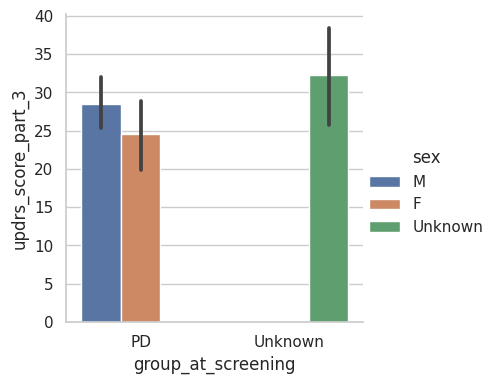

In [19]:
plot_df = pheno_df[pheno_df["redcap_event_name"] == "Baseline (Arm 1: C-OPN)"].copy()

x_col = "group_at_screening"
hue_col = "sex"
plot_col = "updrs_score_part_3" #"updrs_score_part_3"

plot_df = plot_df[~plot_df[plot_col].isna()]
plot_df[plot_col] = plot_df[plot_col].astype(float)

plot_df[x_col] = plot_df[x_col].fillna("Unknown")
# plot_df[x_col] = plot_df[x_col].astype(str).replace({"":"Unknown"})
plot_df[hue_col] = plot_df[hue_col].fillna("Unknown")
# plot_df[hue_col] = plot_df[hue_col].astype(str).replace({"":"Unknown"})

sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    # kwargs = {'join':False, "marker":"d", "scale":1, "linewidth":0}
    g = sns.catplot(x=x_col, y=plot_col, hue=hue_col,
                kind="bar", height=4, aspect=1, data=plot_df, 
                # **kwargs
                )

### Detailed clinical scores

In [20]:
query_df = query_dict["MotorAndNon-Motor"].copy()
query_df = query_df[(query_df["redcap_event_name"] == "Baseline (Arm 1: C-OPN)") & 
                    (query_df["record_id"].isin(nipoppy_participants))]
logger.info(len(query_df))
query_df["updrs_score_part_3"] = query_df["updrs_score_part_3"].replace("", np.nan)
query_df["updrs_score_part_3"] = query_df["updrs_score_part_3"].astype(float)
query_df["updrs_score_part_3"].isna().value_counts()

2023-11-08 15:45:27,666 - nipoppy.workflow.logger - INFO - 256


updrs_score_part_3
False    130
True     126
Name: count, dtype: int64

### CSV Report

In [21]:
sarah_email_xlsx = "/home/nikhil/Downloads/COPN-VictoriaWestonProjec_DATA_LABELS_2023-10-24_1044.xlsx"
report_df = pd.read_excel(sarah_email_xlsx,sheet_name="COPN-VictoriaWestonProjec_DATA_", engine='openpyxl',header=0)
report_df = report_df.rename(columns={"Record ID:":"record_id"})
report_df.head()

,record_id,Event Name,Unnamed: 2,1. Gender/Genre:,"5. Years of education (calculate the total number of years starting from grade 1 onwards including high school and post-secondary (College, University, or others)): 5. Nombre d'années d'études (calculez le nombre total d'années à partir de la première année, y compris l'école secondaire et les études postsecondaires (collège, université ou autres)):","Determined diagnosis: If score = 0, Parkinson's Disease (PD) If score = 1, Progressive Supranuclear Palsy (PSP) If score = 2, Multiple System Atrophy (MSA) If score = 3, Corticobasal Syndrome (CBS) If score = 4, Dementia with Lewy Bodies (DLB) If score = 5, Frontotemporal Dementia (FTD) If score = 6, Essential Tremor (ET) If score = 7, REM Sleep Behaviour Disorder (RBD)",What is the current duration of disease? (years) Quelle est la durée actuelle de la maladie? (years),"8. When the symptoms began, did the symptoms present on one side or both sides of your body? 8. Les symptômes sont-ils apparus d'un seul côté ou des deux côté de votre corps?",10. Do the symptoms affect both sides of your body now? 10. Les symptômes affectent-ils désormais les deux côtés de votre corps?,Date of MoCA administration Date d'administration du MoCA,...,BNT avec IS,BNT avec IP,Was the Purdue plank administered?,Main dominante (30 sec),Main dominante (1 min),Main non dominante (30 sec),Main non dominante (1 min),Deux mains (30 sec),Comments,Complete?
0,CHQ0000,Baseline (Arm 1: C-OPN),NaN,Female/Féminin,9,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Incomplete
1,chq0009,Baseline (Arm 1: C-OPN),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Incomplete
2,CHQ0011,Baseline (Arm 1: C-OPN),NaN,Male/Masculin,16,0.0,5.8,Right side/Côté droit,No (still affects only one side)/Non (affecté ...,2021-11-09 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Incomplete
3,CHQ0011,18 Months Follow-Up/Suivi (Arm 1: C-OPN),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Incomplete
4,CHQ0012,Baseline (Arm 1: C-OPN),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Incomplete


In [28]:
check_subjects = ['MNI0136', 'MNI0147', 'PD00296', 'PD01182', 'PD01253', 'PD01258', 'PD01662', 'PD01686', 'PD01687']

report_df["record_id"] = report_df["record_id"].str.upper()

report_df[report_df["record_id"].isin(check_subjects)]

,record_id,Event Name,Unnamed: 2,1. Gender/Genre:,"5. Years of education (calculate the total number of years starting from grade 1 onwards including high school and post-secondary (College, University, or others)): 5. Nombre d'années d'études (calculez le nombre total d'années à partir de la première année, y compris l'école secondaire et les études postsecondaires (collège, université ou autres)):","Determined diagnosis: If score = 0, Parkinson's Disease (PD) If score = 1, Progressive Supranuclear Palsy (PSP) If score = 2, Multiple System Atrophy (MSA) If score = 3, Corticobasal Syndrome (CBS) If score = 4, Dementia with Lewy Bodies (DLB) If score = 5, Frontotemporal Dementia (FTD) If score = 6, Essential Tremor (ET) If score = 7, REM Sleep Behaviour Disorder (RBD)",What is the current duration of disease? (years) Quelle est la durée actuelle de la maladie? (years),"8. When the symptoms began, did the symptoms present on one side or both sides of your body? 8. Les symptômes sont-ils apparus d'un seul côté ou des deux côté de votre corps?",10. Do the symptoms affect both sides of your body now? 10. Les symptômes affectent-ils désormais les deux côtés de votre corps?,Date of MoCA administration Date d'administration du MoCA,...,BNT avec IS,BNT avec IP,Was the Purdue plank administered?,Main dominante (30 sec),Main dominante (1 min),Main non dominante (30 sec),Main non dominante (1 min),Deux mains (30 sec),Comments,Complete?
